In [1]:
import torch
import numpy as np
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_hex
from places import generate_places
from publib import set_style, fix_style

set_style(['article'])  

In [2]:
network_type = "all"
place_name1 = "huangpu" # huangpu 
place_name2 = "pasadena" # pasadena 
k=16
nchunk=10

data_dir1 = f"../data/{place_name1}/"
data_dir2 = f"../data/{place_name2}/"
places1 = generate_places(place_name1)
places2 = generate_places(place_name2)

In [3]:
# !!!! Note that you need to recreate the dataset, 
# !!!! since the saved city network is not up-to-date!
G1 = ox.graph_from_place(places1, network_type=network_type, retain_all=False)
G2 = ox.graph_from_place(places2, network_type=network_type, retain_all=False)
len(list(G1.nodes)), len(list(G2.nodes))

(5310, 12470)

In [4]:
labels1 = torch.load(f'{data_dir1}{nchunk}-chunk_{k}-hop_node_labels.pt').numpy()
labels2 = torch.load(f'{data_dir2}{nchunk}-chunk_{k}-hop_node_labels.pt').numpy()

/tmp/ipykernel_4171672/3387259628.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels1 = torch.load(f'{data_dir1}{nchunk}-chunk_{k}-hop_node_labels.pt').numpy()
/tmp/

In [11]:
perm1 = torch.as_tensor(np.random.RandomState(seed=0).permutation(labels1.shape[0]))
perm2 = torch.as_tensor(np.random.RandomState(seed=0).permutation(labels2.shape[0]))
labels1_perm = labels1[perm1]
labels2_perm = labels2[perm2]

In [6]:
def get_colors(labels):
    cmap = sns.color_palette("rocket", as_cmap=True)
    palette = cmap(np.linspace(0.1, 0.85, 10))
    palette_hex = [to_hex(color) for color in palette]
    color_array = [palette_hex[index] for index in labels]
    return color_array

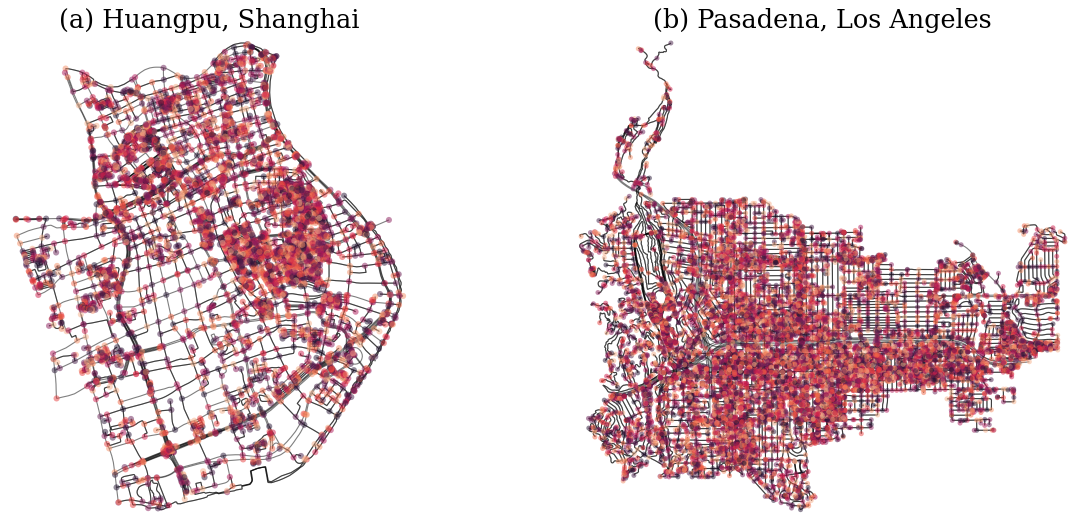

In [12]:
my_font = 23
node_size = 20
fig, ax = plt.subplots(1,2, figsize=(24, 7), gridspec_kw={'width_ratios': [1, 1]})
ox.plot_graph(
    G1, ax=ax[0], node_size=node_size+10, node_color=get_colors(labels1_perm), node_alpha=0.5,
    edge_linewidth=1, edge_color='black', edge_alpha=0.5, show=False, 
)
ox.plot_graph(
    G2, ax=ax[1], node_size=node_size, node_color=get_colors(labels2_perm), node_alpha=0.5,
    edge_linewidth=1, edge_color='black', edge_alpha=0.5, show=False, 
)

ax[0].set_title(f"(a) Huangpu, Shanghai", fontsize=my_font)
ax[1].set_title(f"(b) Pasadena, Los Angeles", fontsize=my_font)


plt.tight_layout(pad=10.0)
fix_style('article')
# plt.savefig(f"../Figures/label_visual_map_{place_name1}_and_{place_name2}_{k}-hop_{nchunk}-chunk.jpg")
plt.show()

In [9]:
d_labels = {
    "paris":"Paris", "shanghai":"Shanghai", "la":"L.A.", "london":"London",
}

d_color = {
    "paris":"#c5373e", # Red, "#9c251c", rgb(197, 55, 62)
    "shanghai":   "#006eae", # Blue, "#00498d", rgb(0, 110, 174)
    "la":  "#439130", # Green, "#1c6e2b",   rgb(67, 145, 48)
    "london":   "#6e788e", # Grey # "#43536a",   rgb(110, 120, 142)
}

d_marker = {"paris":'x', "shanghai":'o', "la":'^', "london":"s"}


eccentricities = {}
for dataset_name in ["paris", "shanghai", "la", "london"]:
    dataset_path = f'../data/{dataset_name}'
    eccentricities[dataset_name] = torch.load(f'{dataset_path}/{k}-hop_eccentricities.pt')

/tmp/ipykernel_4171672/4087259948.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eccentricities[dataset_name] = torch.load(f'{dataset_path}/{k}-hop_eccentricities.pt')

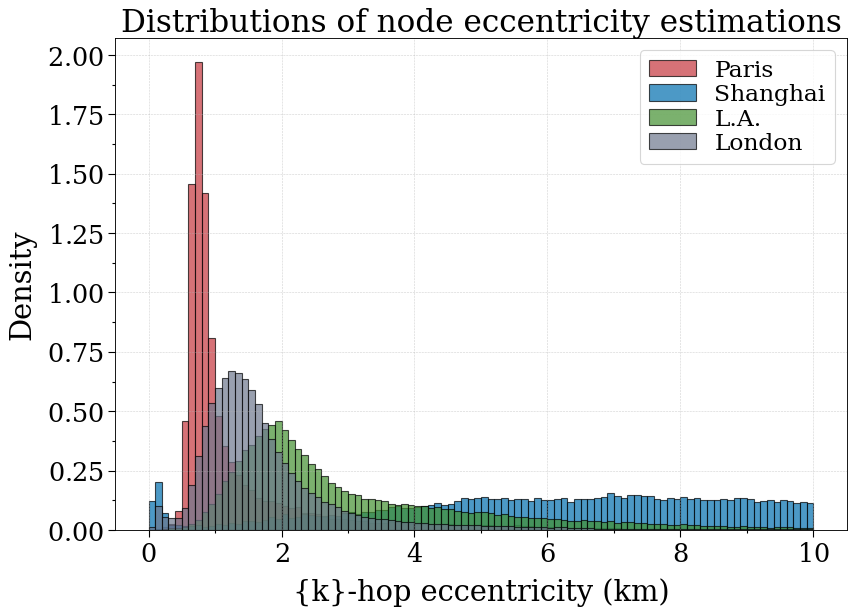

In [10]:
num_bins = 100
fontsize = 26

# Create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(11, 8))

# Plot histograms for each dataset on the same subplot
for dataset_name in ["paris", "shanghai", "la", "london"]:
    ax.hist(
        x=eccentricities[dataset_name]/1000,
        bins=num_bins,
        range=(0, 10),  # Limit the x-axis to focus on the main distribution

        density=True,
        alpha=0.7,
        label=d_labels[dataset_name],
        color=d_color[dataset_name],
        edgecolor='black'
    )


# Set labels and title
ax.set_xlabel("{k}-hop eccentricity (km)", fontsize=fontsize)
ax.set_ylabel("Density", fontsize=fontsize)
ax.set_title("Distributions of node eccentricity estimations", fontsize=fontsize + 2)
ax.tick_params(axis='both', labelsize=fontsize - 3)
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Add gridlines for readability
ax.grid(visible=True, linestyle='--', alpha=0.6)

# Add legend
ax.legend(fontsize=fontsize - 5, frameon=True)

# Apply custom styling and adjust layout
plt.tight_layout()
fix_style('article')
plt.savefig(f"../Figures/label_{k}-hop_eccentricity_distributions.jpg", bbox_inches='tight')
plt.show()